## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [ ]:
!pip uninstall --yes gdown
!pip install gdown -U --no-cache-dir
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Found existing installation: gdown 4.7.3
Uninstalling gdown-4.7.3:
  Successfully uninstalled gdown-4.7.3
Downloading...
From: https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO
To: /content/coco_imgs.npy
100% 83.0M/83.0M [00:00<00:00, 192MB/s]


In [ ]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=da68d82d-4b39-4b75-a61a-173f86b52cd1
To: /content/coco_captions.npy
100% 415M/415M [00:04<00:00, 83.3MB/s]


In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

In [ ]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

coco_dset_1 = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json')

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3]

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [ ]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [ ]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [ ]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [ ]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [ ]:
def accuracy(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy/len(predict)

In [ ]:
import faiss
import numpy as np
import pandas as pd

dim = 512
ind = faiss.IndexFlatL2(dim)
for img in image_embeddings[:40000]:
  tmp = np.array(img,dtype="float32")
  tmp = tmp.reshape(1,-1)
  ind.add(tmp)

In [ ]:
def query_vector(cap_embed, D, I,best_k):

    k = best_k
    temp = D[0]
    temp = temp + 1
    sim = 1 / temp #euclidian similarity

    tempi = I[0]

    nearest_cap_embeddings = cap_embed[tempi, :, :]


    weighted_sum = np.zeros(nearest_cap_embeddings.shape[2])

    for i in range(nearest_cap_embeddings.shape[0]):
        for j in range(nearest_cap_embeddings.shape[1]):
            weighted_sum += nearest_cap_embeddings[i, j] * sim[i]


    result = np.sum(weighted_sum, axis=0)

    normalize = (k * 5)
    q = weighted_sum / normalize

    return q

In [ ]:
import numpy as np
from scipy.spatial.distance import cosine

def rerank_captions(captions_np,l, q1, caption_embeddings, I):
    I = [int(index) for index in I]

    indices = [(index, i) for index in I for i in range(len(caption_embeddings[index]))]
    similarities = [1 - cosine(q1, caption_embeddings[index][i]) for index, i in indices]
    max_index = np.argmax(similarities)

    image_index, caption_index = indices[max_index]

    return captions_np[image_index][caption_index]



In [ ]:
results = {}
min_bs,best_k = -1,-1
actual = []
predicted = []

for k in range(5,20):  # Example k values
    for i in range(40001,40504):
        D, I = ind.search(np.array(image_embeddings[i].reshape(1, -1), dtype='float32'), k)
        actual.append(captions_np[i])
        predicted.append(rerank_captions(captions_np,i, query_vector(caption_embeddings,D, I,k), caption_embeddings, I[0]))
    bleu_scor = accuracy(predicted, actual)
    results[k] = bleu_scor
    print(f'k={k}, BLEU Score={bleu_scor}')
    best_k, min_bs = max(((k, bleu_scor) for k, bleu_scor in results.items()), key=lambda x: x[1])
    actual = []
    predicted = []

    # print(actual)
    # print(predicted)


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

k=5, BLEU Score=0.07762775218707005
k=6, BLEU Score=0.077307799649518
k=7, BLEU Score=0.07388262158656615
k=8, BLEU Score=0.06816541067959904
k=9, BLEU Score=0.06580176903835615
k=10, BLEU Score=0.0653691464919633
k=11, BLEU Score=0.07468723592822296
k=12, BLEU Score=0.07599873166974512
k=13, BLEU Score=0.08375781496668752
k=14, BLEU Score=0.08256935638109435
k=15, BLEU Score=0.08462475822924219
k=16, BLEU Score=0.08226407912199338
k=17, BLEU Score=0.08429168341736365
k=18, BLEU Score=0.09180707016994416
k=19, BLEU Score=0.0908328808962893


Best k: 18


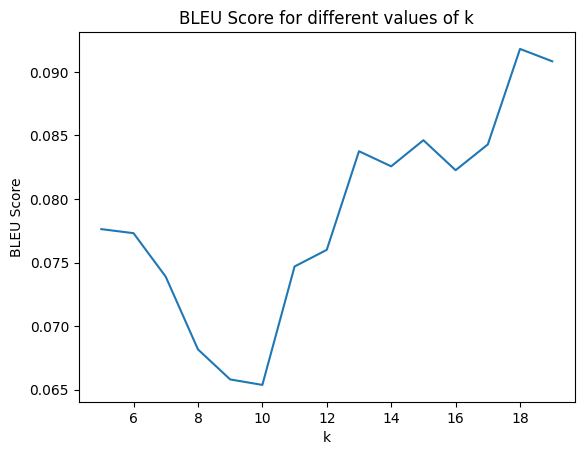

In [ ]:
best_k = max(results, key=lambda k: results[k])
print("Best k:", best_k)

import matplotlib.pyplot as plt
plt.plot(results.keys(), results.values())
plt.xlabel('k')
plt.ylabel('BLEU Score')
plt.title('BLEU Score for different values of k')
plt.show()


#OPTIONS

Flat: 0.09180707016994416
IVF_Flat: 0.08121700898878
IVF_PQ: 0.07183624643198297
HNSW: 0.0949206697508992
PQ: 0.07441368844201145
OPQ: 0.08527811740325565


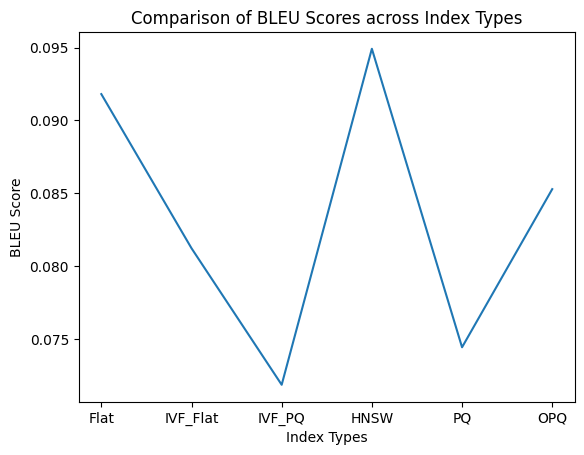

  Index Type  Optimal BLEU Score
0       Flat            0.091807
1   IVF_Flat            0.081217
2     IVF_PQ            0.071836
3       HNSW            0.094921
4         PQ            0.074414
5        OPQ            0.085278


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import faiss
from scipy.spatial.distance import cosine

dimensionality = 512

def retrieve_similar_items(embedding_matrix, query_vectors, idx_type, top_k):
    dim = embedding_matrix.shape[1]
    idx_structure = None

    # Define quantizer for specific indices
    quantizer = faiss.IndexFlatL2(dim) if idx_type in ["IVF_Flat", "IVF_PQ"] else None

    if idx_type == "Flat":
        idx_structure = faiss.IndexFlatL2(dim)
    elif idx_type == "IVF_Flat":
        idx_structure = faiss.IndexIVFFlat(quantizer, dim, 100)
    elif idx_type == "IVF_PQ":
        idx_structure = faiss.IndexIVFPQ(quantizer, dim, 100, 8, 8)
    elif idx_type == "HNSW":
        idx_structure = faiss.IndexHNSWFlat(dim, 32)  # 32 for efConstruction
    elif idx_type == "PQ":
        idx_structure = faiss.IndexPQ(dim, 16, 8)
    elif idx_type == "OPQ":
        m_val = 16  # Subquantizers count
        bits_per_subquantizer = 8  # Bits count per subquantizer
        opq_mat = faiss.OPQMatrix(dim, m_val)
        pq_idx = faiss.IndexPQ(dim, m_val, bits_per_subquantizer)
        idx_structure = faiss.IndexPreTransform(opq_mat, pq_idx)

    if idx_structure:
        if hasattr(idx_structure, 'is_trained') and not idx_structure.is_trained:
            idx_structure.train(embedding_matrix)
        idx_structure.add(embedding_matrix)
        Distances, Indices = idx_structure.search(query_vectors, top_k)
    return Distances, Indices

idx_types = ["Flat", "IVF_Flat", "IVF_PQ", "HNSW", "PQ", "OPQ"]

comparison_results = {}
for idx_type in idx_types:
    ground_truth, predictions = [], []
    max_bleu_score = -1

    feature_vectors = np.array(image_embeddings[:40000])
    query_vectors = np.array(image_embeddings[40001:])
    Distances, Indices = retrieve_similar_items(feature_vectors, query_vectors, idx_type, best_k)

    for idx in range(40001, 40504):
        query_vec = query_vector(caption_embeddings,Distances[idx - 40001:], Indices[idx - 40001:], best_k)
        ranked_captions = rerank_captions(captions_np,idx, query_vec, caption_embeddings, Indices[idx - 40001])
        ground_truth.append(captions_np[idx])
        predictions.append(ranked_captions)

    bleu_scor = accuracy(predictions, ground_truth)
    max_bleu_score = max(bleu_scor, max_bleu_score)
    print(f"{idx_type}: {bleu_scor}")
    comparison_results[idx_type] = max_bleu_score

plt.plot(list(comparison_results.keys()), list(comparison_results.values()))
plt.xlabel('Index Types')
plt.ylabel('BLEU Score')
plt.title('Comparison of BLEU Scores across Index Types')
plt.show()

results_df = pd.DataFrame(list(comparison_results.items()), columns=['Index Type', 'Optimal BLEU Score'])
print(results_df)

In [ ]:
model = ImageCaptioning(512, "IVF_Flat")
D, I = model.search_with_index(features, queries, best_k)

for i in range(test_start, test_start+5):
    q = model.compute_query_vector(D[i - test_start:], I[i - test_start:], caption_embeddings, best_k)
    closest_captions = model.rerank_captions(i, q, caption_embeddings, I[i - test_start], captions_np)
    img1, target1 = coco_dset1[i]

    plt.imshow(img1)
    plt.axis('off')
    plt.show()
    original_caption = captions_np[i]

    print("Original Caption:")
    print(original_caption)

    print("\nClosest Caption:")
    print(closest_captions)

    print("=" * 80)

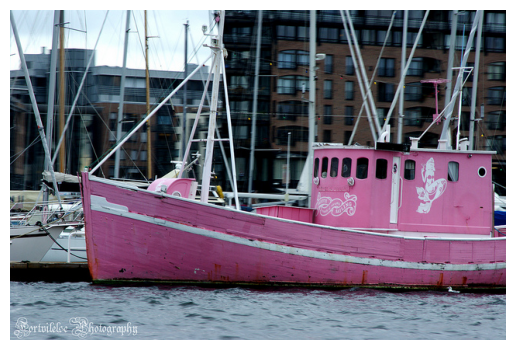

Original Caption:
['A pink boat at a dock with brick buildings in the background.'
 'A bright pink fishing boat moored in a harbor.'
 'Pink shit sitting at a peer next to a building. '
 'A pink boat in harbor of a larger city'
 'a sickly pink fishing boat with a mermaid imprint on the side of cabin']

Closest Caption:
A medium sized boat parked near the dock 


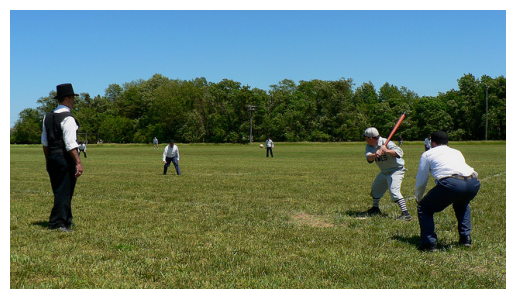

Original Caption:
['A man holding a baseball bat during a baseball game.'
 'Group of men playing baseball on an open makeshift field. '
 'A group of Amish people play baseball in a field.'
 'A baseball player waiting for the pitcher to throw the ball.'
 'A man in a best and top hat standing on a grass field while a baseball game is played.']

Closest Caption:
many people are playing frisbee on some grass


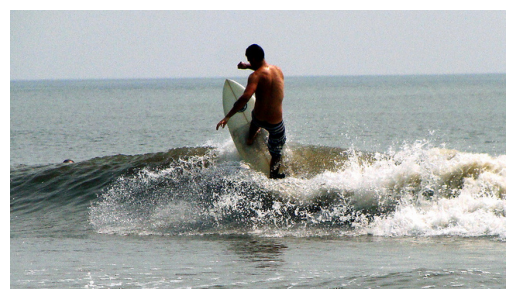

Original Caption:
['Guy climbs a wave on his surfboard in the ocean'
 'A shirtless man surfboarding on wave with sky in the background.'
 'Surfing working back up a wave as it is dying out'
 'a person riding a surf board on a wave'
 'A man surfs in a small gray wave.']

Closest Caption:
A man on a surfboard surfing on a wave.


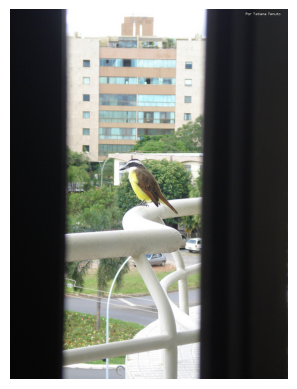

Original Caption:
['A bird that is sitting on a ledge.'
 'The bird perched atop the white railing overlooking the city.'
 'A bird sits on the balcony rail of a high rise building.'
 'a brown and yellow bird is sitting on a white railing'
 'A bird is perched on the railing of a high rise building.']

Closest Caption:
A bird that is sitting on a bird feeder.


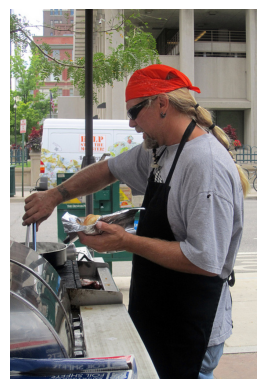

Original Caption:
['A man holding a foil wrap in his hand near a stove.'
 'A man makes a hotdog at a street vendor cart.'
 'a guy that is cooking some kind of food'
 'A man with a bandanna on serving himself food.'
 'Man with ponytail digging out condiment for sandwich in hand']

Closest Caption:
a man buying some food at a food stand


In [ ]:
ground_truth, predictions = [], []
max_bleu_score = -1

feature_vectors = np.array(image_embeddings[:40000])
query_vectors = np.array(image_embeddings[40001:])
Distances, Indices = retrieve_similar_items(feature_vectors, query_vectors, 'HNSW', best_k)

for idx in range(40001, 40006):
    query_vec = query_vector(caption_embeddings,Distances[idx - 40001:], Indices[idx - 40001:], best_k)
    ranked_captions = rerank_captions(captions_np,idx, query_vec, caption_embeddings, Indices[idx - 40001])
    ground_truth.append(captions_np[idx])
    img1, target1 = coco_dset_1[idx]

    plt.imshow(img1)
    plt.axis('off')
    plt.show()
    original_caption = captions_np[idx]

    print("Original Caption:")
    print(original_caption)

    print("\nClosest Caption:")
    print(ranked_captions)
    print("=" * 80)
